In [1]:
import pandas as pd
import numpy as np

#### This is read the gust for expriments in Dashuai et.al

In [2]:
data = pd.read_csv("naca0012_AOA_-4_GUST_20_gust_extrapolation.csv")#时间长度264一个case

In [3]:
inputs_usecols=[]
for i in range(1,10,1):
    #传感器9个
    inputs_usecols.append(f'Cp_{i}')
    

In [34]:
inputs_usecols

['Cp_1', 'Cp_2', 'Cp_3', 'Cp_4', 'Cp_5', 'Cp_6', 'Cp_7', 'Cp_8', 'Cp_9']

In [4]:
pressure_csv_data = pd.read_csv("naca0012_AOA_-4_GUST_20_gust_extrapolation.csv", usecols= inputs_usecols)

In [7]:
pressure_data_80000 = pressure_csv_data.to_numpy()

# 首先，确保数据的行数可以被121
assert pressure_data_80000.shape[0] % 1 == 0

# 计算每个分组应该有多少行
rows_per_group = pressure_data_80000.shape[0] // 1

# 重塑数组到新的形状 (121, 264, 9)
pressure_data = pressure_data_80000.reshape(1,264,pressure_data_80000.shape[1])

In [8]:
print("New shape:", pressure_data.shape)

New shape: (1, 264, 9)


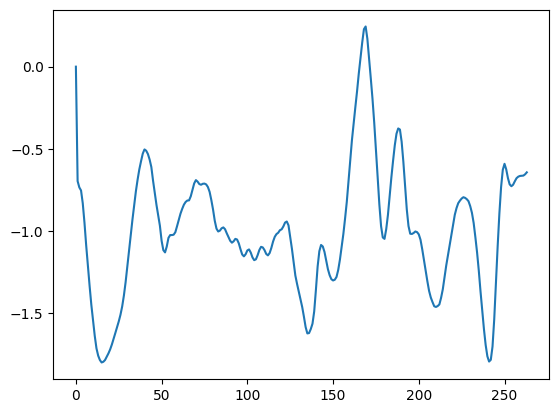

In [9]:
import matplotlib.pyplot as plt
plt.plot(pressure_data[0,:,1])

#### 拿到力的数据

In [12]:

outputs_usecols=['CL']
output_csv_data = pd.read_csv("naca0012_AOA_-4_GUST_20_gust_extrapolation.csv",usecols=outputs_usecols)
output_data_80000 = output_csv_data.to_numpy()
#every 2500 is a case
# 首先，确保数据的行数可以被32整除
assert output_data_80000.shape[0] % 1 == 0


# 计算每个分组应该有多少行
out_per_group = output_data_80000.shape[0] // 1

# 重塑数组到新的形状 (121, 264, 1)
out_data = output_data_80000.reshape(1, out_per_group, 1)

In [13]:
out_data.shape

(1, 264, 1)

In [14]:
corr = pd.read_csv("foil_coordinates.csv",usecols=["X","Y"])
aoa_x_y = corr.to_numpy()

In [15]:
# 使用 np.repeat 来沿特定轴重复数据
coord = aoa_x_y[1:10]

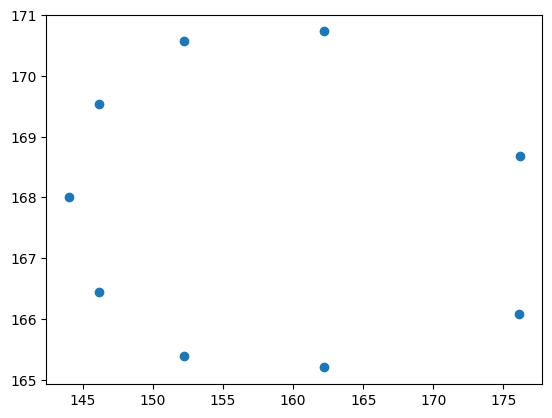

In [16]:
plt.scatter(coord[0:9,0],coord[0:9,1])

In [17]:
import torch

In [18]:

def calculate_distance_matrix(coords):
    num_points = coords.shape[0]
    distance_matrix = np.zeros((num_points, num_points))

    for i in range(num_points):
        for j in range(num_points):
            distance_matrix[i, j] = np.linalg.norm(coords[i] - coords[j])
    return distance_matrix

# 计算连接矩阵
def calculate_adj_matrix(coords, epsilon=1e-5):
    # 计算距离矩阵
    distance_matrix = calculate_distance_matrix(coords)

    # 创建连接矩阵，基于反距离
    adj_matrix = np.zeros_like(distance_matrix)
    for i in range(distance_matrix.shape[0]):
        for j in range(distance_matrix.shape[1]):
            if i != j and distance_matrix[i, j] != 0:
                adj_matrix[i, j] = 1 / (distance_matrix[i, j] + epsilon)

    # 行归一化连接矩阵
    row_sums = adj_matrix.sum(axis=1, keepdims=True)
    adj_matrix_normalized = adj_matrix / (row_sums + epsilon)
    
    return adj_matrix_normalized



In [19]:
adj = calculate_adj_matrix(coord)

In [21]:
adj_matrix_batch = np.tile(adj, (1, 1, 1))

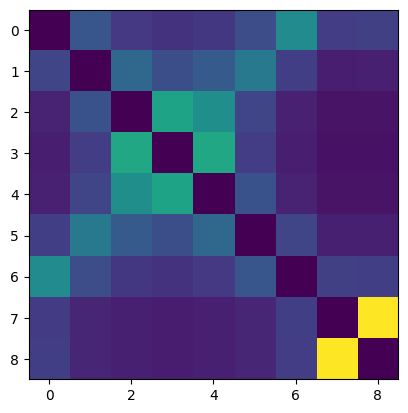

In [48]:
import matplotlib.pyplot as plt
plt.imshow(adj_matrix_batch[0,:,:])

In [23]:
pressure_data.shape

(1, 264, 9)

In [24]:
from torch.utils.data import DataLoader, TensorDataset, random_split
import torch
# 创建一个TensorDataset
# 将NumPy数组转换为PyTorch张量 250长度
pressure_data = torch.tensor(pressure_data[:,14:], dtype=torch.float32)
pressure_coords = torch.tensor(adj_matrix_batch, dtype=torch.float32)
force_output = torch.tensor(out_data[:,14:], dtype=torch.float32)

dataset = TensorDataset(pressure_data, pressure_coords, force_output)



In [25]:
#检查每个部分的数据大小
print("Training set size:", len(dataset))


Training set size: 1


In [26]:
# 保存train_dataset
dict = {
   "test_dataset":dataset,
}
# 保存字典到.pt文件
torch.save(dict, 'simulations_extra-4.pt')